# Машинное обучение 2020, часть 2, семинар 4. Кластеризация

Сегодня мы рассмотрим два алгоритма кластеризации:
* KMeans: самый простой и популярный. Рассмотрим его необычное применение: к уменьшению количества цветов на изображении
* Gaussian Mixture Models: алгоритм с вероятностной интерпретацией. Он нам даже позволит генерировать новые данные

## KMeans

**Напоминание**. Концепции, на которых построен KMeans:
* центр кластера - среднее арифметическое всех элементов кластера
* каждый элемент находится ближе к центру своего кластера, чем к центру любого другого

Как всегда, исследование начинаем на довольно простых датасетах:

In [ ]:
from matplotlib import pyplot as plt

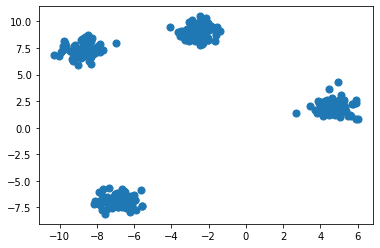

In [ ]:
from sklearn.datasets.samples_generator import make_blobs

X, y_true = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=42)
plt.scatter(X[:, 0], X[:, 1], s=50)

Кажется, ну задачка для кластеризации прям совсем простая. А значит с ней справится и [`sklearn.cluster.KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) без дополнительных настроек :)

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

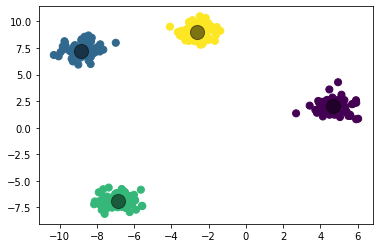

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

**Задание 1 (1 балл)**. Проста для стандартного библиотечного метода, значит проста и для вас! Реализуйте собственную версию алгоритма KMeans. Проверьте её на приведённых выше данных и убедитесь, что визуализация решения выглядит так же убедительно!

In [ ]:
import numpy as np

In [ ]:
from sklearn.base import BaseEstimator

class MySpectaculousKMeans(BaseEstimator):
  def __init__(self, n_clusters=5, max_iter=300, threashold=1e-4, 
               init='random', random_state=42):
    self.n_clusters = n_clusters
    self.max_iter = max_iter
    self.threashold = threashold
    self.init = init
    self.random_state = random_state

    np.random.seed(self.random_state)

  def _compute_clusters(self, X):
    X = X[:, np.newaxis, :]
    X = X.repeat(repeats=self.n_clusters, axis=1)
    distances = ((X - self.cluster_centers_) ** 2).sum(axis = 2)
    clusters = np.argmin(distances, axis=1)
    return clusters

  def _kpp_init(self, X):
    cluster_centers = [X[0]]

    for iter in range(1, self.n_clusters):
      dist = np.array([min([np.inner(center - x, center - x) for center in cluster_centers]) for x in X])
      probs = dist / dist.sum()
      cum_probs = probs.cumsum()
      r = np.random.rand()

      for j, prob in enumerate(cum_probs):
        if r < prob:
          idx = j
          break

      cluster_centers.append(X[idx])
    return np.array(cluster_centers)

  def fit(self, X, y=None):
    X_size = len(X)
    assert X_size >= self.n_clusters, f"n_samples={X_size} should be >= n_clusters={self.n_clusters}"

    # random init
    if self.init == 'random':
      self.cluster_centers_ = X[np.random.randint(0, X_size, self.n_clusters), :]
    elif self.init == 'kpp':
      self.cluster_centers_ = self._kpp_init(X)
    else:
      raise ValueError('Wrong initialization type')

    for i in range(self.max_iter):
      clusters = self._compute_clusters(X)

      new_centers = np.zeros((self.n_clusters, X.shape[1]))
      for cluster in range(self.n_clusters):
        new_centers[cluster] = X[clusters == cluster].mean(axis=0)
      
      self.error = np.linalg.norm(new_centers - self.cluster_centers_)
      # print(i, self.error)
      if self.error < self.threashold:
        break

      self.cluster_centers_ = new_centers
  
  def predict(self, X):
    return self._compute_clusters(X)


In [ ]:
# Random init, random_state = 42
spect_kmeans = MySpectaculousKMeans(n_clusters=4)
spect_kmeans.fit(X)
y_kmeans = spect_kmeans.predict(X)

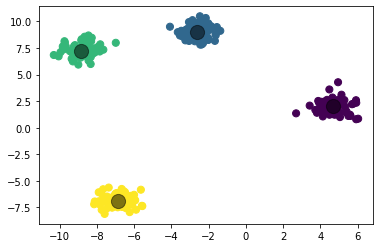

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)

centers = spect_kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
# KPP init, random_state=42
spect_kmeans = MySpectaculousKMeans(n_clusters=4, init='kpp')
spect_kmeans.fit(X)
y_kmeans = spect_kmeans.predict(X)

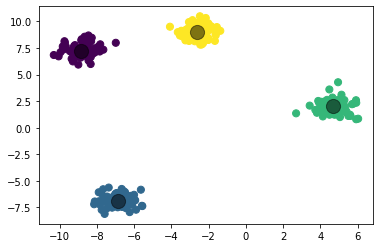

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)

centers = spect_kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

Зная количество кластеров задачу может кто угодно решить! А что же делать, если количество кластеров нам неизвестно и хочется его автоматически подобрать?

Идея! Раз мы пытаемся добиться того, чтобы среднее расстояние между точками в кластере было как можно меньше, давайте эту метрику и возьмём за метрику качества. То значение количества кластеров, при котором метрика минимальна, и есть оптимальное.

$$
    J(C) = \sum\limits_{k=0}^K\sum\limits_{i\in C_k} ||x_i - \mu_k||^2 \to \min_{C}
$$

К сожалению, не всё так просто. Найдите подвох в предыдущем рассуждении :)

Из-за обсуждённых выше проблем чаще всего в качестве количества кластеров берут количество, при котором J(C) начинает падать уже "не так сильно", а именно

$$
D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|} \to \min_k
$$

**Задание 2 (0.5 балла)**. Реализуйте оба критерия качества. Постройте графики зависимости одного и второго от количества кластеров для обоих реализаций KMeans: своей и из sklearn. Подберите оптимальное значение количества кластеров с помощью второго критерия качества.

In [ ]:
def J_metric(X, y, cluster_centers):
  n_clusters = len(cluster_centers)

  metrics = 0
  for cluster in range(n_clusters):
    metrics += np.linalg.norm(X[y == cluster] - cluster_centers[cluster], axis=0).sum()

  return metrics

In [ ]:
def D_metrics(X, y, cluster_centers):
  '''
  cluster_centers - array [3, n_clusters, X.shape[1]]
  '''
  return np.abs(J_metric(X, y, cluster_centers[1]) - J_metric(X, y, cluster_centers[2])) / \
          np.abs(J_metric(X, y, cluster_centers[0]) - J_metric(X, y, cluster_centers[1]))

In [ ]:
min_clusters = 1
max_clusters = 25

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
kmeans_J = []
spect_kmeans_J = []

for k in tqdm(range(min_clusters, max_clusters+1)):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)

  spect_kmeans = MySpectaculousKMeans(n_clusters=k, init='kpp')
  spect_kmeans.fit(X)

  y_kmeans = kmeans.predict(X)
  y_spect_kmeans = spect_kmeans.predict(X)

  kmeans_J.append(J_metric(X, y_kmeans, kmeans.cluster_centers_))
  spect_kmeans_J.append(J_metric(X, y_spect_kmeans, spect_kmeans.cluster_centers_))

kmeans_J = np.array(kmeans_J)
spect_kmeans_J = np.array(spect_kmeans_J)

In [ ]:
print(f'KMeans: min_J = {np.min(kmeans_J):.5f}, n_clusters = {np.argmin(kmeans_J) + 1}.')
print(f'MySpectaculousKMeans: min_J = {np.min(spect_kmeans_J):.5f}, n_clusters = {np.argmin(spect_kmeans_J) + 1}.')

KMeans: min_J = 40.32932, n_clusters = 4.
MySpectaculousKMeans: min_J = 40.32932, n_clusters = 4.


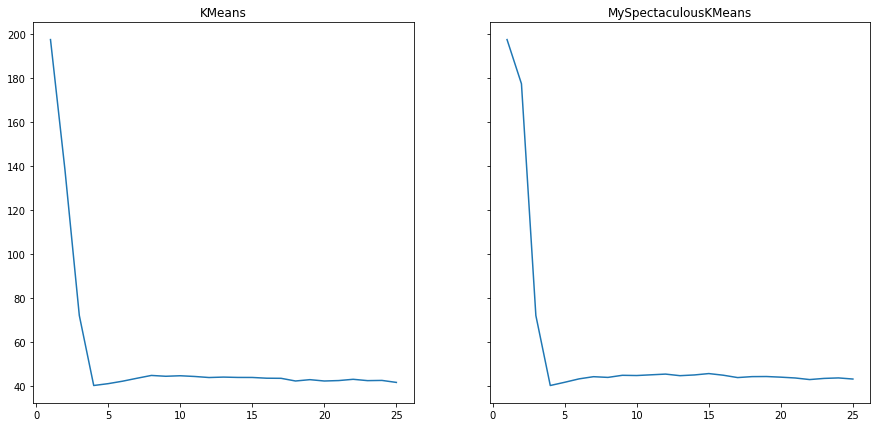

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axes[0].plot(range(min_clusters, max_clusters+1), kmeans_J)
axes[0].set_title('KMeans')
axes[1].plot(range(min_clusters, max_clusters+1), spect_kmeans_J)
axes[1].set_title('MySpectaculousKMeans')
plt.show()

In [ ]:
kmeans_D = np.abs(kmeans_J[1:-1] - kmeans_J[2:]) / np.abs(kmeans_J[:-2] - kmeans_J[1:-1])
spect_kmeans_D = np.abs(spect_kmeans_J[1:-1] - spect_kmeans_J[2:]) / np.abs(spect_kmeans_J[:-2] - spect_kmeans_J[1:-1])

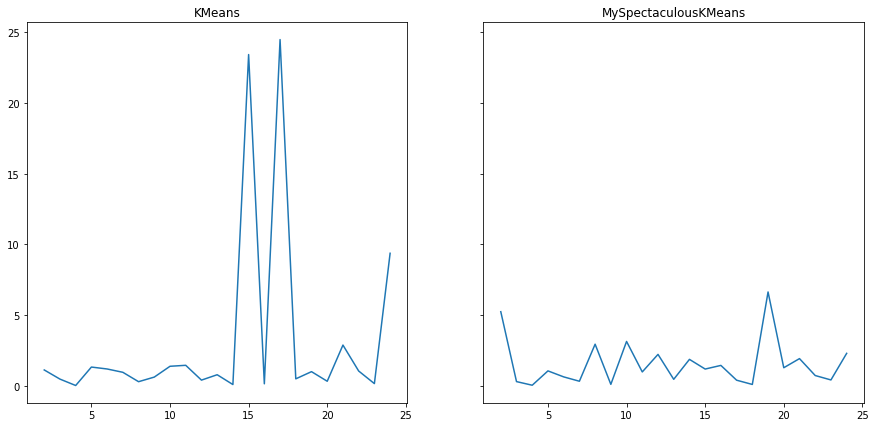

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
axes[0].plot(range(min_clusters+1, max_clusters), kmeans_D)
axes[0].set_title('KMeans')
axes[1].plot(range(min_clusters+1, max_clusters), spect_kmeans_D)
axes[1].set_title('MySpectaculousKMeans')
plt.show()

In [ ]:
print(f'KMeans: min_J = {np.min(kmeans_D):.5f}, n_clusters = {np.argmin(kmeans_D) + 2}.')
print(f'MySpectaculousKMeans: min_J = {np.min(spect_kmeans_D):.5f}, n_clusters = {np.argmin(spect_kmeans_D) + 2}.')

KMeans: min_J = 0.02639, n_clusters = 4.
MySpectaculousKMeans: min_J = 0.04606, n_clusters = 4.


## Недостатки KMeans

**Напоминание**. Алгоритм KMeans - это реализация EM-алгоритма. Он представляет из себя итеративный процесс: на одном шаге пересчитываются центры кластеров, а на другом - принадлежность объектов кластерам.

Из этого (и не только) следуют некоторые из основных недостатков KMeans:
* гарантия сходимости - есть, гарантия глобального оптимума - нет
* необходимо заранее указывать число кластеров

* ограничение на пространственную структуру данных

In [385]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

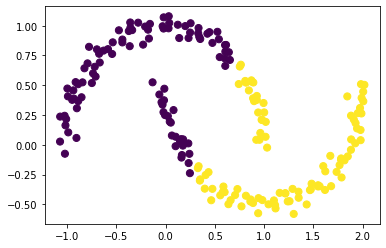

In [386]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50)

Благо, не KMeans одним едины. Есть метод Spectral Clustering, который основан на "соседских" взаимоотношениях и с такой задачей справиться может:

/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


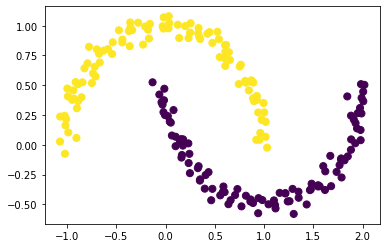

In [384]:
from sklearn.cluster import SpectralClustering

model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50)

**Задача 3 (0.5 балла)**. А что KMeans? Всё же не справится? Нет, мы этого не позволим! Найдите преобразование пространства, которое поможет KMeans достойно отработать и на этих данных. Визуализируйте результат, полученный при кластеризации в новом пространстве, на исходных данных в старом пространстве.

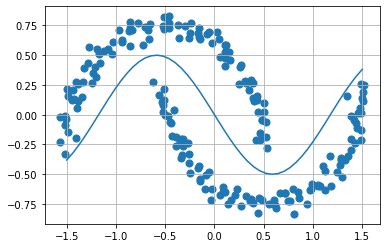

In [403]:
X_train = X - X.mean(axis=0)

x_space = np.linspace(-1.5, 1.5)
plt.scatter(X_train[:, 0], X_train[:, 1], s=50)
plt.plot(x_space, -0.5*np.sin(0.85*np.pi * x_space))
plt.grid(which='major')
plt.show()

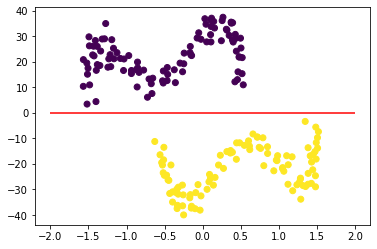

In [407]:
X_train = X - X.mean(axis=0)
sin_values = -0.5*np.sin(0.85*np.pi * X_train[:, 0])
X_train[:, 1] -= sin_values
X_train[:, 1] *= 50

plt.scatter(X_train[:, 0], X_train[:, 1], c=y)
plt.hlines(0, -2, 2, color='#ff0000')

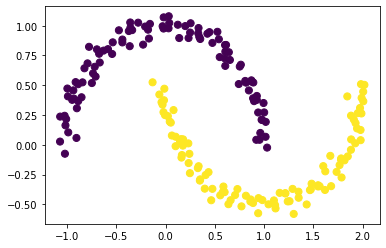

In [408]:
labels = KMeans(2, random_state=0).fit_predict(X_train)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50)

* может быть медленным на большом количестве данных. Чтобы избежать этого, есть Mini Batch KMeans

## Сжатие изображения с помощью KMeans

Применим KMeans в достаточно необычной для себя роли: уменьшим количество цветов на изображении без особой потери его визуального качества.

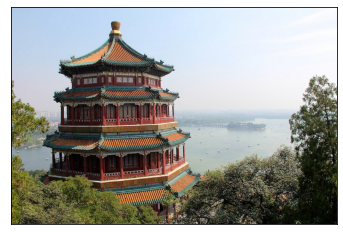

In [ ]:
from sklearn.datasets import load_sample_image

china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china)

Картинка представляет из себя матрицу пикселей:

In [ ]:
china.shape

(427, 640, 3)

В целом это множество можно рассматривать как множество отдельно взятых пикселей, каждый своего цвета (точнее, трёх цветов):

In [ ]:
data = china / 255.0
data = data.reshape(-1, 3)
data.shape

(273280, 3)

А вот уже и объекты, которые можно кластеризовать!

Но перед этим давайте посмотрим на структуру визуально:

In [ ]:
import numpy as np

In [ ]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

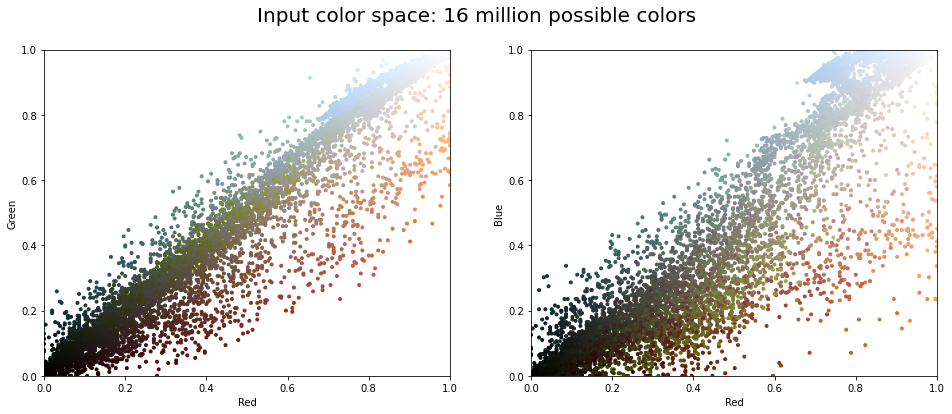

In [ ]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Получается, что у нас есть порядка 16 миллионов цветов! Многовато. Воспользуемся KMeans и уменьшим это количество.

Т.к. выборка у нас довольно большая (273000 объектов), стандартный вариант будет работать долго. В связи с этим, воспользуемся MiniBatchKMeans:

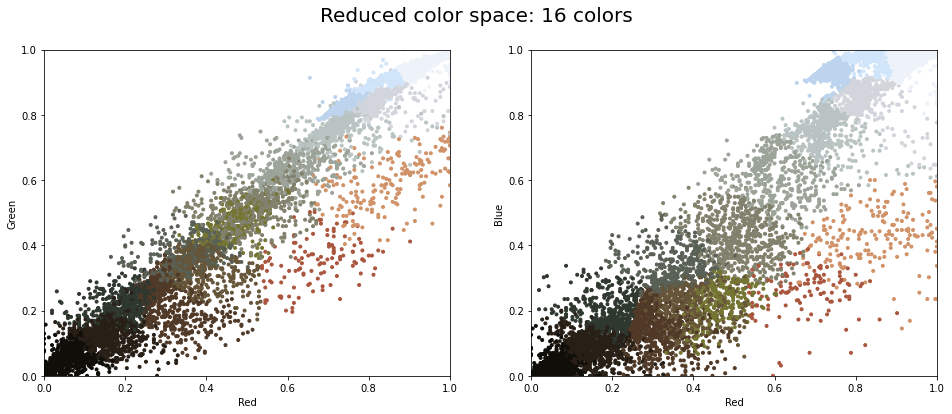

In [ ]:
import warnings; warnings.simplefilter('ignore')
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors, title="Reduced color space: 16 colors")

Даже на этой визуадизации наглядно видно, как сильно уменьшилось количество цветов! Но не пострадала ли от этого исходная картинка?

Text(0.5, 1.0, '16-color Image')

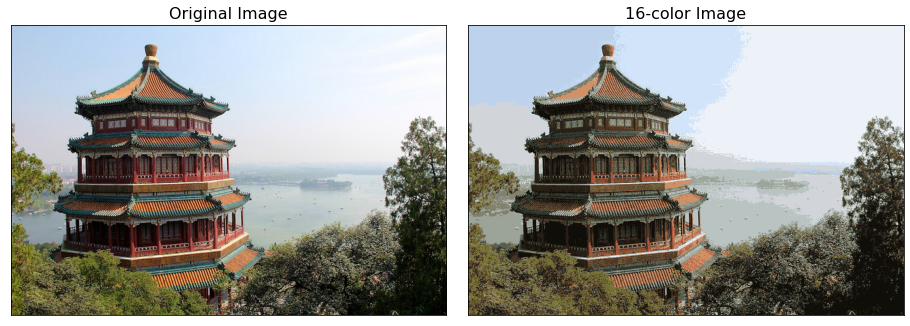

In [ ]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)

Да, неидеально, но, оказывается, в целом хватает и 16 цветов.
Выигрыш по памяти же колоссальный. Вместо 3 байт на пиксель мы обходимся всего лишь 4 битами!

## Gaussian Mixture Models (GMM)

У KMeans есть ещё 2 неочевидных, но довольно важных недостатка:

* объект принадлежит ровно одному кластеру. Причём нет никакой возможности численно оценить уверенность принадлежности, ведь чем ближе к центру кластера - тем более вероятно, что объект действительно ему принадлежит

* исходя из наших формул, кластеры могут иметь только круговую структуру. Центр круга будет в центре кластера, а радиус - расстояние до самого далёкого от центра объекта в кластере

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, zorder=2)

    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

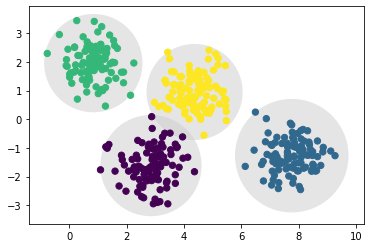

In [ ]:
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Однако даже если преобразовать эти данные, то круги уже будут не так подходить:

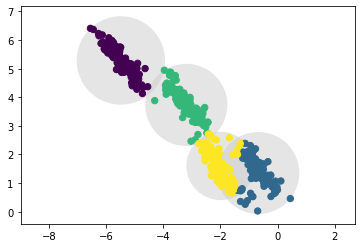

In [ ]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

На картинке выше явно выражены эллипсоидные структуры. Однако сказать, что кластер представляет из себя эллипсоид, возможности у KMeans нет...

В целом можно придумать, как бороться с этими двумя недостатками:
* считать вероятность принадлежности точки кластеру на основании расстояния не только до своего центра кластера, но и до остальных
* разрешить кластерам иметь вид эллипсоидов

Эти идеи и лежат в основе Gaussian Mixture Models

Математически мы хотим всего лишь предполагаем, что все наши объекты сэмплируются из смеси гауссовских распределений. Каждое распределение отвечает за один свой кластер:
$$
p(x) = \sum\limits_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k)
$$

Их центры - это $\mu_k$, а форма задаётся с помощью $\Sigma_k$.

Использовать этот метод можно аналогично KMeans:

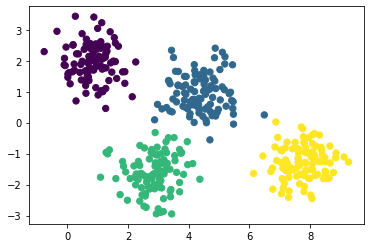

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

Результаты выглядят вполне нормально.

Т.к. GMM по своей сути метод, основанный на вероятностной модели, он позволяет считать и вероятности принадлежности объектов кластеру. Давайте попробуем это визуализировать с помощью размера точек. Чем он меньше - тем меньше вероятность принадлежности своему кластеру:

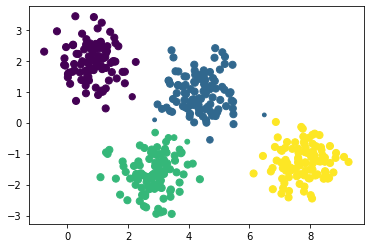

In [ ]:
probs = gmm.predict_proba(X)
size = 50 * probs.max(1) ** 2
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size)

С точки зрения EM-алгоритма GMM выглядит примерно так же, как и KMeans:
* E-шаг: для каждой точки пересчитываем веса, показывающие вероятность принадлежности каждому из кластеров
* М-шаг: для каждого кластера пересчитываем центр, а также размеры кластера по всем измерениям

Для наглядности визуализируем те самые эллипсы, да ещё и показывающие структуры кластеров и вероятности:

In [ ]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

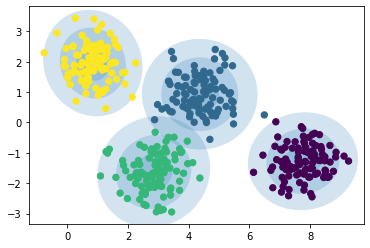

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

Для преобразованных нами выше данных это выглядит ещё более наглядно:

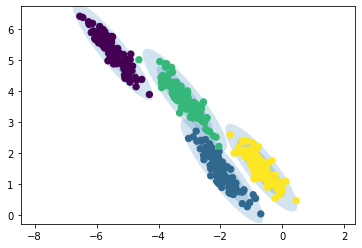

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X_stretched)

У [`sklearn.mixture.GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html?highlight=gmm) есть один интересный параметр: `covariance_type`. С помощью него можно задавать ограничения на матрицу ковариации:
* `spherical`: у каждой компоненты своя ковариация, но одинакова для всех координат, т.е. имеем сферы в качестве кластеров
* `diag`: у каждой компоненты своя диагональная матрица ковариации, т.е. имеем сферы, с осями параллельно осям координат
* `tied`: у всех компонент одинаковая матрица ковариации, но без ограничений, т.е. все кластеры имеют одинаковую, но при этом произвольную эллипсоидную форму
* `full`: как `tied`, но у каждой компоненты своя матрица ковариации

## GMM для восстановления плотности

Вспомним про датасет с двумя лунами и проверим: может быть GMM справится лучше, чем KMeans?

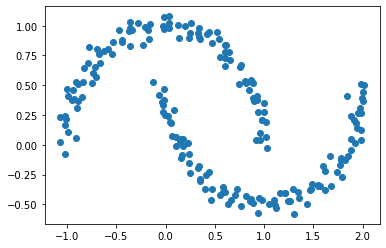

In [ ]:
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1])

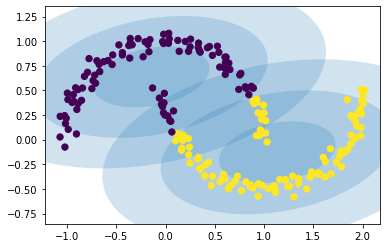

In [ ]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

![](https://i.ibb.co/VHHsHN9/Screenshot-from-2020-10-18-18-13-29.png)

А что же, если увеличить количество кластеров?

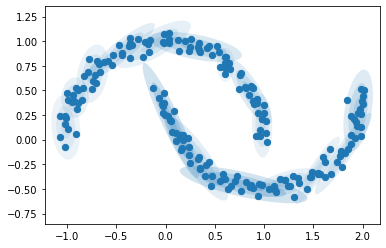

In [ ]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Итак, с одной стороны, мы не разбили на два кластера так, как умеет человек. Но с другой стороны, получили довольно хорошее приближение на распределение плотности этой выборки!

Причём мы из него даже можем семплировать новые данные:

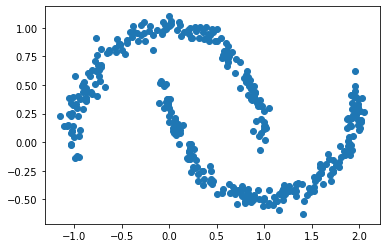

In [ ]:
Xnew, ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1])

В самом начале занятия было обещено, что в GMM можно проще выбрать число кластеров. Да, можно, ведь теперь у нас задача приобретает более чёткий смысл: надо подобрать параметры модели, чтобы правдоподобие было как можно больше.

**Задача 4 (0.5 балла)**. Как всегда, без вас это никто не сделает! Используйте кросс-валидацию для подбора оптимального значения кластеров для наших исходных данных:

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture 

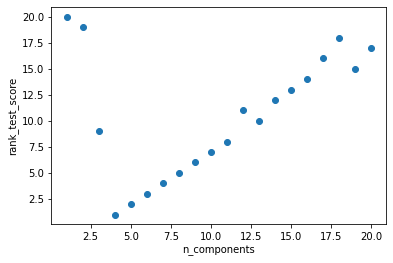

In [ ]:
X, y_true = make_blobs(n_samples=400, centers=4, cluster_std=0.60, random_state=0)
X = X[:, ::-1]

param_grid = {'n_components': np.arange(1, 21)}
clf = GridSearchCV(GaussianMixture(), param_grid, cv=5)
clf.fit(X)

plt.scatter(clf.cv_results_['param_n_components'],\
            clf.cv_results_['rank_test_score'])
plt.xlabel("n_components")
plt.ylabel("rank_test_score")
plt.show()

 Видим, что с ростом компонент растет и наше правдоподобие. Это происходит из-за того, что модель разделяет наши данные на кластеры все меньшего размера и все больше походит на данные.

Однако есть и более хитрые способы это сделать. Например, информационные критерии, такие как [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) и [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion), встроенные прямо в реализацию GMM:

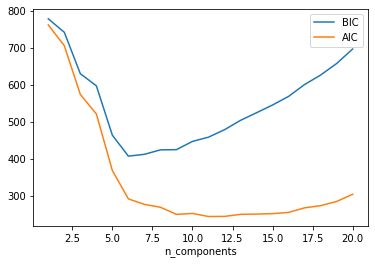

In [ ]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

## Генерация данных с помощью GMM

Мы увидели лишь небольшой пример генерации данных с помощью GMM. И, скажем честно, не очень впечатляющий. Более впечатляющий пример может получиться, если взять более интересные данные и... сделать всё своими руками!

Для начала загрузим и визуализируем наш любимый классический MNIST:

In [288]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

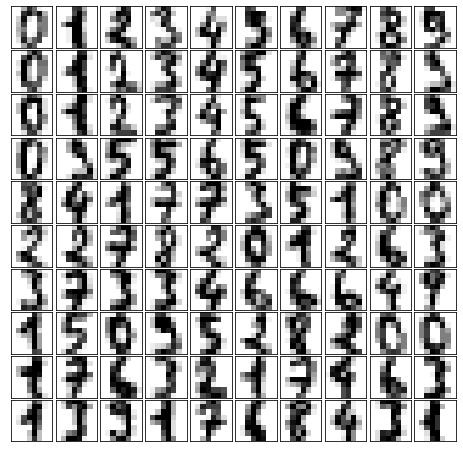

In [289]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

**Задание 5 (1.5 балла)**. Цель: с помощью GMM сгенерировать новые цифры.

Шаги для достижения цели:

* размерность нашего пространства равна 64 (каждая цифра имеет размер 8*8). Это будет тяжеловато для GMM. Давайте уменьшим с помощью PCA да так, чтобы сохранить примерно 99% от исходной дисперсии

In [290]:
from sklearn.decomposition import PCA

In [291]:
pca = PCA(n_components=0.99, svd_solver='full')
X_pca = pca.fit_transform(digits.data)
print(X_pca.shape)

(1797, 41)


* строим график зависимости AIC от количества кластеров для этой задачи, выбираем оптимальное

In [304]:
n_components = np.arange(50, 310, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X_pca)
          for n in n_components]

In [306]:
aics = [m.aic(X_pca) for m in models]

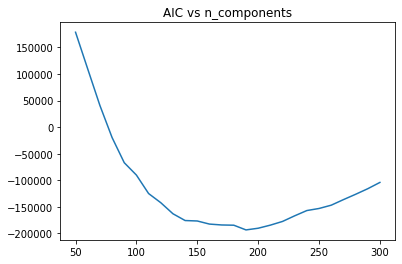

In [305]:
plt.plot(np.arange(50, 310, 10), aics)
plt.title("AIC vs n_components")
plt.show()

In [308]:
best_comp = np.arange(50, 310, 10)[np.argmin(aics)]
best_comp

190

* семплируем новые объекты и рисуем их, используя обратное преобразование из PCA, наслаждаемся результатом

In [311]:
gmm = GaussianMixture(best_comp, covariance_type='full', random_state=42)
gmm.fit(X_pca)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=190, n_init=1,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [318]:
new_digits = gmm.sample(100)[0]
new_digits.shape

(100, 41)

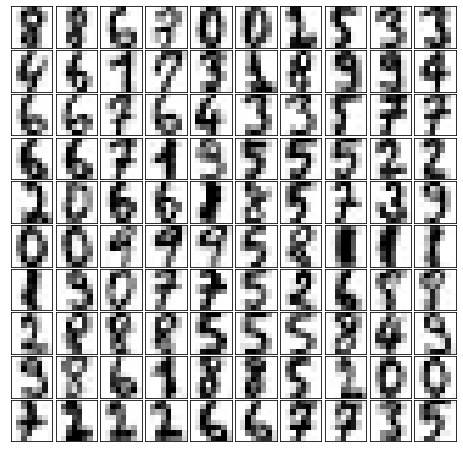

In [319]:
new_digits = pca.inverse_transform(new_digits)
plot_digits(new_digits)